In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def train_model(net, loss_fn, batchsize, trainset, valset, optimizer, num_epochs):

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)

    valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize,
                                         shuffle=False, num_workers=2)
    train_accuracies = []; val_accuracies = []
    train_losses = []; val_losses = []
    
    N = num_epochs
    net = net.cuda()
    loss_fn = loss_fn.cuda()

    for epoch in range(N):  # loop over the dataset multiple times
        correct = 0.0
        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, _, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            max_scores, max_labels = outputs.max(1)
            correct += (max_labels == labels).sum().item()
            if (i+1) % (20) == 0:    # print every 10 mini-batches
                print('Train: [%d, %5d] loss: %.3f Accuracy: %.4f' %
                      (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
                running_loss = 0.0
        
        train_accuracies.append(correct / len(trainset))
        train_losses.append(running_loss / (i + 1))  

        net.eval()
        correct = 0
        running_loss = 0
        for i, data in enumerate(valloader, 0):
            inputs, labels, _, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)
            running_loss += loss_fn(outputs, labels).item()

            max_scores, max_labels = outputs.max(1)
            correct += (max_labels == labels).sum().item()

        print('Validation: [%d, %5d] loss: %.3f Accuracy: %.4f' % 
              (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
        
        val_accuracies.append(correct / len(valset))
        val_losses.append(running_loss / (i + 1))
            

    print('Finished Training')

In [3]:
import torch.utils.data
import json, os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class UVaBuildinglabel(torch.utils.data.Dataset):
    def __init__(self, image_path, annotation_filepath, transform = None):
        super(UVaBuildinglabel, self).__init__()
        
        print('Loading data...')
        data = pd.read_csv(annotation_filepath)              #json.load(open(annotation_filepath, 'rb'))
        
        self.transform = transforms.Compose(
        [transforms.Resize(320),  # 1. Resize smallest side to 256.
        transforms.RandomCrop(320), # 2. Crop random square of 224x224 pixels.
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
        
        self.image_path = image_path    # storing image path. 
        
        
        # get the image pixel values and labels
        image_ids = data.iloc[:, 0 ]
        label_ids = data.iloc[:, 1]
        label_names = data.iloc[:, 2]

        self.image_ids = data.iloc[:, 0 ] #[img_name for (img_id, img_name) in paired_id_names]
        self.image_labels = data.iloc[:, 1]   #[img_id for (img_id, img_name) in paired_id_names]
        self.image_classes= data.iloc[:, 2]


        print(image_ids[0])
        print(label_ids[0])
        print(label_names)

        
    def __getitem__(self, index):
        image_name = self.image_ids[index]
        img_ = Image.open(open(os.path.join(self.image_path, image_name), 'rb'))
        img_ = img_.convert("RGB")
        if self.transform:
            img_ = self.transform(img_)
        label_ = self.image_labels[index]
        class_name= self.image_classes[index]
        return img_, label_,image_name,class_name
    
    def __len__(self):
        return len(self.image_ids)
       
      
# You can unnormalize the transformation of torch's transforms.normalize 
# with this custom transformation.
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


trainset = UVaBuildinglabel('Data', 'trainSet.csv')
valset = UVaBuildinglabel('Data', 'valSet.csv')

Loading data...
alderman1.jpg
0
0      Alderman Library
1      Alderman Library
2      Alderman Library
3      Alderman Library
4      Alderman Library
             ...       
409       Wilsdorf Hall
410       Wilsdorf Hall
411       Wilsdorf Hall
412       Wilsdorf Hall
413       Wilsdorf Hall
Name: name, Length: 414, dtype: object
Loading data...
alderman9.jpg
0
0     Alderman Library
1     Alderman Library
2     Alderman Library
3     Alderman Library
4          Alumni Hall
            ...       
88       Wilsdorf Hall
89       Wilsdorf Hall
90       Wilsdorf Hall
91       Wilsdorf Hall
92       Wilsdorf Hall
Name: name, Length: 93, dtype: object


In [10]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
resnetPretrained = models.resnet50(pretrained = True)
resnetPretrained.fc = nn.Linear(2048, len(trainset.image_classes))
optimizer = optim.SGD(resnetPretrained.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(resnetPretrained, loss_fn, 4, trainset, valset, optimizer, 5)

Train: [1,    20] loss: 6.990 Accuracy: 0.0250
Train: [1,    40] loss: 3.291 Accuracy: 0.0500
Train: [1,    60] loss: 2.180 Accuracy: 0.0542
Train: [1,    80] loss: 1.773 Accuracy: 0.0938
Train: [1,   100] loss: 1.597 Accuracy: 0.1125
Validation: [1,    24] loss: 3.635 Accuracy: 0.2083
Train: [2,    20] loss: 3.751 Accuracy: 0.2750
Train: [2,    40] loss: 2.279 Accuracy: 0.2938
Train: [2,    60] loss: 1.818 Accuracy: 0.3375
Train: [2,    80] loss: 1.545 Accuracy: 0.3594
Train: [2,   100] loss: 1.441 Accuracy: 0.3700
Validation: [2,    24] loss: 2.557 Accuracy: 0.6979
Train: [3,    20] loss: 3.064 Accuracy: 0.5000
Train: [3,    40] loss: 1.891 Accuracy: 0.5250
Train: [3,    60] loss: 1.586 Accuracy: 0.5208
Train: [3,    80] loss: 1.385 Accuracy: 0.5531
Train: [3,   100] loss: 1.298 Accuracy: 0.5875
Validation: [3,    24] loss: 1.954 Accuracy: 0.7500
Train: [4,    20] loss: 2.398 Accuracy: 0.6875
Train: [4,    40] loss: 1.575 Accuracy: 0.7312
Train: [4,    60] loss: 1.351 Accuracy: 0.775

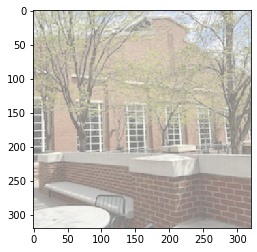

GroundTruth:  ('Aquatic & Fitness Center',)
Predicted:  Aquatic & Fitness Center


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

classes = ['Alderman Library', 'Alumni Hall', 'Aquatic & Fitness Center', 'Chemical Engineering Building', 'John Paul Jones Arena', 
           'Law School Building', 'Mechanical Building', 'Memorial Gym', 'Monroe Hall', 
           'Newcomb Hall', 'North Grounds Gym', 'Old Cabell Hall', 'Olsson Hall', 
           'Physics Building', 'Rice Hall', 'The Rotunda', 'Scott Stadium', 'Slaughter Recreation',
           'Thornton Hall', 'Wilsdorf Hall']

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#do some predictions
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = resnetPretrained(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])


In [13]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = resnetPretrained(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

resnetPretrainedAccuracy = open('results/resnetPretrainedAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    resnetPretrainedAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
resnetPretrainedAccuracy.close()  

resnetPretrainedConfusion = open('results/resnetPretrainedConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    resnetPretrainedConfusion.write(line)
resnetPretrainedConfusion.close()

accuracy for  Alderman Library is :  1.0
accuracy for  Alumni Hall is :  1.0
accuracy for  Aquatic & Fitness Center is :  0.800000011920929
accuracy for  Chemical Engineering Building is :  0.4000000059604645
accuracy for  John Paul Jones Arena is :  0.800000011920929
accuracy for  Law School Building is :  1.0
accuracy for  Mechanical Building is :  1.0
accuracy for  Memorial Gym is :  1.0
accuracy for  Monroe Hall is :  1.0
accuracy for  Newcomb Hall is :  0.75
accuracy for  North Grounds Gym is :  1.0
accuracy for  Old Cabell Hall is :  1.0
accuracy for  Olsson Hall is :  1.0
accuracy for  Physics Building is :  1.0
accuracy for  Rice Hall is :  1.0
accuracy for  The Rotunda is :  1.0
accuracy for  Scott Stadium is :  1.0
accuracy for  Slaughter Recreation is :  1.0
accuracy for  Thornton Hall is :  1.0
accuracy for  Wilsdorf Hall is :  1.0


In [15]:
loss_fn = nn.CrossEntropyLoss()
mobilenetPretrained = models.mobilenet_v2(pretrained=True)
mobilenetPretrained.fc = nn.Linear(2048, len(trainset.image_classes))
optimizer = optim.SGD(mobilenetPretrained.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(mobilenetPretrained, loss_fn, 4, trainset, valset, optimizer, 5)

Train: [1,    20] loss: 9.393 Accuracy: 0.0125
Train: [1,    40] loss: 3.549 Accuracy: 0.1000
Train: [1,    60] loss: 2.002 Accuracy: 0.1917
Train: [1,    80] loss: 1.704 Accuracy: 0.2406
Train: [1,   100] loss: 1.349 Accuracy: 0.3000
Validation: [1,    24] loss: 1.973 Accuracy: 0.7604
Train: [2,    20] loss: 2.136 Accuracy: 0.6875
Train: [2,    40] loss: 1.490 Accuracy: 0.7375
Train: [2,    60] loss: 1.281 Accuracy: 0.7625
Train: [2,    80] loss: 1.166 Accuracy: 0.7781
Train: [2,   100] loss: 1.136 Accuracy: 0.7900
Validation: [2,    24] loss: 1.421 Accuracy: 0.8750
Train: [3,    20] loss: 1.424 Accuracy: 0.9000
Train: [3,    40] loss: 1.268 Accuracy: 0.8562
Train: [3,    60] loss: 1.129 Accuracy: 0.8750
Train: [3,    80] loss: 1.117 Accuracy: 0.8781
Train: [3,   100] loss: 1.105 Accuracy: 0.8700
Validation: [3,    24] loss: 1.314 Accuracy: 0.8958
Train: [4,    20] loss: 1.350 Accuracy: 0.9125
Train: [4,    40] loss: 1.164 Accuracy: 0.9125
Train: [4,    60] loss: 1.061 Accuracy: 0.929

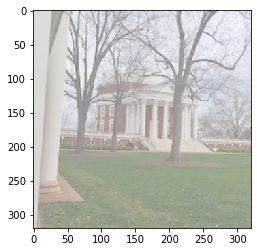

GroundTruth:  ('The Rotunda',)
Predicted:  The Rotunda


In [16]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenetPretrained(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [18]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = mobilenetPretrained(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

mobilenetPretrainedAccuracy = open('results/mobilenetPretrainedAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    mobilenetPretrainedAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
mobilenetPretrainedAccuracy.close()  

mobilenetPretrainedConfusion = open('results/mobilenetPretrainedConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    mobilenetPretrainedConfusion.write(line)
mobilenetPretrainedConfusion.close()

accuracy for  Alderman Library is :  1.0
accuracy for  Alumni Hall is :  1.0
accuracy for  Aquatic & Fitness Center is :  1.0
accuracy for  Chemical Engineering Building is :  0.800000011920929
accuracy for  John Paul Jones Arena is :  0.800000011920929
accuracy for  Law School Building is :  0.8333333134651184
accuracy for  Mechanical Building is :  1.0
accuracy for  Memorial Gym is :  1.0
accuracy for  Monroe Hall is :  1.0
accuracy for  Newcomb Hall is :  0.75
accuracy for  North Grounds Gym is :  1.0
accuracy for  Old Cabell Hall is :  1.0
accuracy for  Olsson Hall is :  1.0
accuracy for  Physics Building is :  1.0
accuracy for  Rice Hall is :  1.0
accuracy for  The Rotunda is :  1.0
accuracy for  Scott Stadium is :  1.0
accuracy for  Slaughter Recreation is :  1.0
accuracy for  Thornton Hall is :  1.0
accuracy for  Wilsdorf Hall is :  1.0


In [19]:
loss_fn = nn.CrossEntropyLoss()
alexnetPretrained = models.alexnet(pretrained=True)
alexnetPretrained.classifier[6] = nn.Linear(4096, len(trainset.image_classes))
optimizer = optim.SGD(alexnetPretrained.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(alexnetPretrained, loss_fn, 4, trainset, valset, optimizer, 5)

Train: [1,    20] loss: 6.020 Accuracy: 0.0500
Train: [1,    40] loss: 2.689 Accuracy: 0.0938
Train: [1,    60] loss: 1.911 Accuracy: 0.1708
Train: [1,    80] loss: 1.625 Accuracy: 0.1938
Train: [1,   100] loss: 1.404 Accuracy: 0.2350
Validation: [1,    24] loss: 2.883 Accuracy: 0.4896
Train: [2,    20] loss: 2.443 Accuracy: 0.5875
Train: [2,    40] loss: 1.828 Accuracy: 0.5437
Train: [2,    60] loss: 1.426 Accuracy: 0.5625
Train: [2,    80] loss: 1.285 Accuracy: 0.5844
Train: [2,   100] loss: 1.266 Accuracy: 0.5825
Validation: [2,    24] loss: 1.944 Accuracy: 0.6458
Train: [3,    20] loss: 2.014 Accuracy: 0.6750
Train: [3,    40] loss: 1.481 Accuracy: 0.6937
Train: [3,    60] loss: 1.302 Accuracy: 0.6875
Train: [3,    80] loss: 1.246 Accuracy: 0.6937
Train: [3,   100] loss: 1.173 Accuracy: 0.6975
Validation: [3,    24] loss: 1.841 Accuracy: 0.7812
Train: [4,    20] loss: 1.358 Accuracy: 0.9000
Train: [4,    40] loss: 1.280 Accuracy: 0.8438
Train: [4,    60] loss: 1.186 Accuracy: 0.812

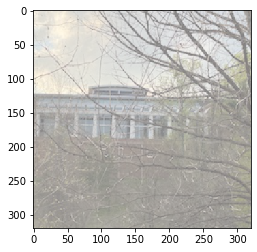

GroundTruth:  ('John Paul Jones Arena',)
Predicted:  Wilsdorf Hall


In [20]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = alexnetPretrained(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [21]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = alexnetPretrained(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

alexnetPretrainedAccuracy = open('results/alexnetPretrainedAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    alexnetPretrainedAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
alexnetPretrainedAccuracy.close()  

alexnetPretrainedConfusion = open('results/alexnetPretrainedConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    alexnetPretrainedConfusion.write(line)
alexnetPretrainedConfusion.close()

accuracy for  Alderman Library is :  0.75
accuracy for  Alumni Hall is :  1.0
accuracy for  Aquatic & Fitness Center is :  0.6000000238418579
accuracy for  Chemical Engineering Building is :  1.0
accuracy for  John Paul Jones Arena is :  0.6000000238418579
accuracy for  Law School Building is :  1.0
accuracy for  Mechanical Building is :  1.0
accuracy for  Memorial Gym is :  1.0
accuracy for  Monroe Hall is :  0.75
accuracy for  Newcomb Hall is :  0.25
accuracy for  North Grounds Gym is :  1.0
accuracy for  Old Cabell Hall is :  1.0
accuracy for  Olsson Hall is :  1.0
accuracy for  Physics Building is :  1.0
accuracy for  Rice Hall is :  1.0
accuracy for  The Rotunda is :  1.0
accuracy for  Scott Stadium is :  1.0
accuracy for  Slaughter Recreation is :  1.0
accuracy for  Thornton Hall is :  1.0
accuracy for  Wilsdorf Hall is :  1.0


In [48]:
loss_fn = nn.CrossEntropyLoss()

resnet = models.resnet50()
resnet.fc = nn.Linear(2048, len(trainset.image_classes))
optimizer = optim.SGD(resnet.parameters(), lr=5e-4, momentum=0.9)

train_model(resnet, loss_fn, 4, trainset, valset, optimizer, 10)

Train: [1,    20] loss: 6.377 Accuracy: 0.0250
Train: [1,    40] loss: 2.915 Accuracy: 0.0312
Train: [1,    60] loss: 2.248 Accuracy: 0.0333
Train: [1,    80] loss: 1.877 Accuracy: 0.0344
Train: [1,   100] loss: 1.817 Accuracy: 0.0325
Validation: [1,    24] loss: 6.657 Accuracy: 0.0938
Train: [2,    20] loss: 4.977 Accuracy: 0.0375
Train: [2,    40] loss: 2.865 Accuracy: 0.0625
Train: [2,    60] loss: 2.188 Accuracy: 0.0542
Train: [2,    80] loss: 1.816 Accuracy: 0.0625
Train: [2,   100] loss: 1.694 Accuracy: 0.0525
Validation: [2,    24] loss: 4.706 Accuracy: 0.0833
Train: [3,    20] loss: 4.756 Accuracy: 0.0625
Train: [3,    40] loss: 2.770 Accuracy: 0.0688
Train: [3,    60] loss: 2.093 Accuracy: 0.0833
Train: [3,    80] loss: 1.845 Accuracy: 0.0813
Train: [3,   100] loss: 1.702 Accuracy: 0.0775
Validation: [3,    24] loss: 4.785 Accuracy: 0.0938
Train: [4,    20] loss: 4.415 Accuracy: 0.1625
Train: [4,    40] loss: 2.663 Accuracy: 0.1250
Train: [4,    60] loss: 2.080 Accuracy: 0.133

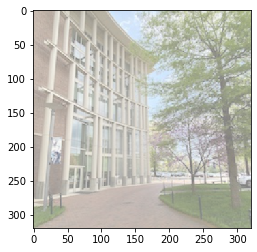

GroundTruth:  ('Rice Hall',)
Predicted:  Physics Building


In [49]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = resnet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [50]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = resnet(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

resnetAccuracy = open('results/resnetAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    resnetAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
resnetAccuracy.close()  

resnetConfusion = open('results/resnetConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    resnetConfusion.write(line)
resnetConfusion.close()

accuracy for  Alderman Library is :  0.0
accuracy for  Alumni Hall is :  0.0
accuracy for  Aquatic & Fitness Center is :  0.0
accuracy for  Chemical Engineering Building is :  0.0
accuracy for  John Paul Jones Arena is :  0.0
accuracy for  Law School Building is :  0.8333333134651184
accuracy for  Mechanical Building is :  1.0
accuracy for  Memorial Gym is :  0.0
accuracy for  Monroe Hall is :  0.25
accuracy for  Newcomb Hall is :  0.0
accuracy for  North Grounds Gym is :  0.25
accuracy for  Old Cabell Hall is :  0.0
accuracy for  Olsson Hall is :  0.0
accuracy for  Physics Building is :  1.0
accuracy for  Rice Hall is :  0.0
accuracy for  The Rotunda is :  0.0
accuracy for  Scott Stadium is :  0.0
accuracy for  Slaughter Recreation is :  0.6000000238418579
accuracy for  Thornton Hall is :  0.4000000059604645
accuracy for  Wilsdorf Hall is :  0.0


In [47]:
loss_fn = nn.CrossEntropyLoss()
mobilenet = models.mobilenet_v2()
mobilenet.fc = nn.Linear(2048, len(trainset.image_classes))
optimizer = optim.SGD(mobilenet.parameters(), lr=5e-4, momentum=0.9)

train_model(mobilenet, loss_fn, 4, trainset, valset, optimizer, 10)

Train: [1,    20] loss: 8.058 Accuracy: 0.0250
Train: [1,    40] loss: 4.046 Accuracy: 0.0375
Train: [1,    60] loss: 2.728 Accuracy: 0.0542
Train: [1,    80] loss: 2.121 Accuracy: 0.0531
Train: [1,   100] loss: 1.807 Accuracy: 0.0550
Validation: [1,    24] loss: 4.954 Accuracy: 0.0625
Train: [2,    20] loss: 4.742 Accuracy: 0.0500
Train: [2,    40] loss: 2.758 Accuracy: 0.0437
Train: [2,    60] loss: 2.141 Accuracy: 0.0375
Train: [2,    80] loss: 1.830 Accuracy: 0.0375
Train: [2,   100] loss: 1.665 Accuracy: 0.0400
Validation: [2,    24] loss: 4.314 Accuracy: 0.0729
Train: [3,    20] loss: 4.312 Accuracy: 0.0500
Train: [3,    40] loss: 2.682 Accuracy: 0.0250
Train: [3,    60] loss: 2.067 Accuracy: 0.0292
Train: [3,    80] loss: 1.804 Accuracy: 0.0344
Train: [3,   100] loss: 1.628 Accuracy: 0.0350
Validation: [3,    24] loss: 4.205 Accuracy: 0.0417
Train: [4,    20] loss: 4.238 Accuracy: 0.1000
Train: [4,    40] loss: 2.597 Accuracy: 0.0625
Train: [4,    60] loss: 2.052 Accuracy: 0.066

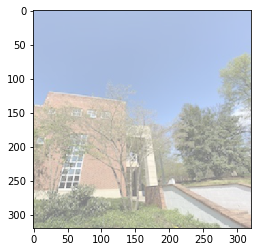

GroundTruth:  ('Chemical Engineering Building',)
Predicted:  Thornton Hall


In [51]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [53]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = mobilenet(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

mobilenetAccuracy = open('results/mobilenetAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    mobilenetAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
mobilenetAccuracy.close()  

mobilenetConfusion = open('results/mobilenetConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    mobilenetConfusion.write(line)
mobilenetConfusion.close()

accuracy for  Alderman Library is :  0.0
accuracy for  Alumni Hall is :  0.0
accuracy for  Aquatic & Fitness Center is :  0.0
accuracy for  Chemical Engineering Building is :  0.0
accuracy for  John Paul Jones Arena is :  0.0
accuracy for  Law School Building is :  0.1666666716337204
accuracy for  Mechanical Building is :  0.20000000298023224
accuracy for  Memorial Gym is :  0.0
accuracy for  Monroe Hall is :  0.0
accuracy for  Newcomb Hall is :  0.0
accuracy for  North Grounds Gym is :  0.0
accuracy for  Old Cabell Hall is :  0.800000011920929
accuracy for  Olsson Hall is :  0.20000000298023224
accuracy for  Physics Building is :  0.4000000059604645
accuracy for  Rice Hall is :  0.8333333134651184
accuracy for  The Rotunda is :  0.6000000238418579
accuracy for  Scott Stadium is :  0.0
accuracy for  Slaughter Recreation is :  0.800000011920929
accuracy for  Thornton Hall is :  0.800000011920929
accuracy for  Wilsdorf Hall is :  0.0


In [56]:
loss_fn = nn.CrossEntropyLoss()
alexnet = models.alexnet()
alexnet.classifier[6] = nn.Linear(4096, len(trainset.image_classes))
optimizer = optim.SGD(alexnet.parameters(), lr=5e-4, momentum=0.9)

train_model(alexnet, loss_fn, 4, trainset, valset, optimizer, 10)

Train: [1,    20] loss: 7.340 Accuracy: 0.0000
Train: [1,    40] loss: 4.085 Accuracy: 0.0187
Train: [1,    60] loss: 3.037 Accuracy: 0.0250
Train: [1,    80] loss: 2.520 Accuracy: 0.0281
Train: [1,   100] loss: 2.212 Accuracy: 0.0250
Validation: [1,    24] loss: 7.251 Accuracy: 0.0625
Train: [2,    20] loss: 7.300 Accuracy: 0.0750
Train: [2,    40] loss: 4.067 Accuracy: 0.0750
Train: [2,    60] loss: 3.026 Accuracy: 0.0583
Train: [2,    80] loss: 2.511 Accuracy: 0.0531
Train: [2,   100] loss: 2.204 Accuracy: 0.0525
Validation: [2,    24] loss: 7.212 Accuracy: 0.1042
Train: [3,    20] loss: 7.263 Accuracy: 0.0750
Train: [3,    40] loss: 4.049 Accuracy: 0.0625
Train: [3,    60] loss: 3.011 Accuracy: 0.0583
Train: [3,    80] loss: 2.500 Accuracy: 0.0594
Train: [3,   100] loss: 2.196 Accuracy: 0.0525
Validation: [3,    24] loss: 7.167 Accuracy: 0.0625
Train: [4,    20] loss: 7.217 Accuracy: 0.1250
Train: [4,    40] loss: 4.024 Accuracy: 0.1000
Train: [4,    60] loss: 2.993 Accuracy: 0.087

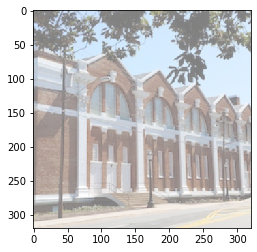

GroundTruth:  ('Memorial Gym',)
Predicted:  Law School Building


In [58]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = alexnet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [59]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = alexnet(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

alexnetAccuracy = open('results/alexnetAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    alexnetAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
alexnetAccuracy.close()  

alexnetConfusion = open('results/alexnetConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    alexnetConfusion.write(line)
alexnetConfusion.close()

accuracy for  Alderman Library is :  0.0
accuracy for  Alumni Hall is :  0.0
accuracy for  Aquatic & Fitness Center is :  0.0
accuracy for  Chemical Engineering Building is :  0.6000000238418579
accuracy for  John Paul Jones Arena is :  0.0
accuracy for  Law School Building is :  1.0
accuracy for  Mechanical Building is :  0.0
accuracy for  Memorial Gym is :  0.0
accuracy for  Monroe Hall is :  0.0
accuracy for  Newcomb Hall is :  0.0
accuracy for  North Grounds Gym is :  0.0
accuracy for  Old Cabell Hall is :  0.0
accuracy for  Olsson Hall is :  0.0
accuracy for  Physics Building is :  0.0
accuracy for  Rice Hall is :  0.0
accuracy for  The Rotunda is :  0.0
accuracy for  Scott Stadium is :  0.0
accuracy for  Slaughter Recreation is :  0.0
accuracy for  Thornton Hall is :  0.0
accuracy for  Wilsdorf Hall is :  0.0
